In [62]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn import svm

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

cvxopt_solvers.options['show_progress'] = False

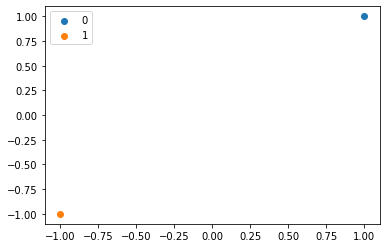

In [528]:
N = 2
X = np.zeros((N,2))

c1, c2 = [1,1], [-1,-1]
sigma = 1
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

X = X-np.mean(X,axis=0)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)

plt.scatter(X[Y==0,0],X[Y==0,1],label = '0')
plt.scatter(X[Y==1,0],X[Y==1,1],label = '1')
plt.legend()


In [417]:

def distance_matrix(A, B, squared=False):
   
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared
    

In [418]:
from scipy.spatial import distance

K = np.dot(X , X.T) * 1.


Indices of support vectors =  (array([  1,   2,   3,   4,   6,   8,   9,  10,  12,  15,  16,  18,  20,
        21,  23,  25,  27,  29,  30,  31,  35,  37,  41,  42,  44,  46,
        47,  48,  50,  51,  52,  53,  56,  61,  62,  63,  65,  66,  68,
        69,  70,  71,  73,  74,  75,  76,  78,  79,  84,  85,  86,  88,
        89,  91,  95,  99, 100, 101, 103, 105, 106, 107, 109, 110, 111,
       112, 114, 116, 117, 119, 120, 122, 123, 124, 126, 127, 128, 129,
       130, 132, 133, 134, 135, 136, 138, 140, 141, 143, 144, 146, 147,
       148, 149, 151, 152, 153, 154, 159, 161, 162, 163, 164, 165, 167,
       169, 170, 174, 175, 177, 179, 181, 183, 185, 188, 189, 190, 191,
       194, 195, 198, 200, 201, 202, 204, 206, 207, 209, 211, 212, 213,
       214, 219, 220, 221, 223, 224, 225, 226, 227, 229, 230, 231, 232,
       234, 235, 236, 239, 240, 243, 244, 245, 246, 248, 249, 250, 251,
       253, 254, 255, 256, 257, 258, 262, 263, 264, 267, 269, 271, 272,
       274, 275, 276, 277, 278, 2

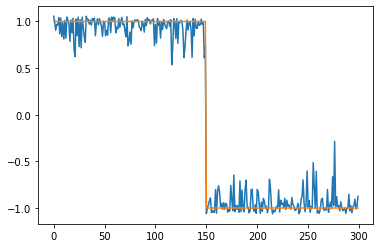

In [457]:

def SVM(K,Y,C=1.):
    N = K.shape[0]
    G = np.vstack([np.eye(N,N),-np.eye(N,N)])

    # C = 1/2/N/lmbda
    
    h = np.concatenate([np.repeat(C,N),np.repeat(0,N)]).astype(np.double)
    label = -1.*np.logical_not(Y)+1.*Y
    P = np.diag(label)@K@np.diag(label)
    np.testing.assert_array_equal(P,P.transpose())

    A = np.matrix(label)
    b = np.zeros(1)
    q = -np.ones((N,1))


    P = cvxopt_matrix(P)
    G =cvxopt_matrix(G)
    h =cvxopt_matrix(h)
    b =cvxopt_matrix(b)
    A =cvxopt_matrix(A)
    q =cvxopt_matrix(q)

    # print(f'{P=}')
    # print(f'{q=}')
    # print(f'{G=}')
    # print(f'{h=}')
    # print(f'{A=}')
    # print(f'{b=}')

    sol = cvxopt_solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b, )
    alphas = np.array(sol['x'])

    return alphas

def pred(gram,Y,alphas):
    label = -1.*np.logical_not(Y)+1.*Y
    return gram.dot(alphas*label)

C = 1

get_K = RBF_K
K = get_K(X,X)
gram = get_K(X,X)


alphas = SVM(K,Y,C = C)

S = (alphas > 1e-4).flatten()
# # b = y[S] - np.dot(X[S], w)
print('Indices of support vectors = ',np.where(S))
print('Alphas = ',alphas[alphas > 1e-4])

print('Support vectors = ', X[S])
print('Number of support vectors for each class = ', np.sum(S))

label = -1.*np.logical_not(Y)+1.*Y
alphas = np.squeeze(alphas)

y = pred(gram,Y,alphas)

plt.plot(y)
plt.plot(label)


b =  [-0.05324944]
Indices of support vectors =  [153 154 292 294   6  22  85 108]
Support vectors =  [[ 1.86331962  0.88461438]
 [ 1.13362312  1.99791882]
 [ 1.72712931  1.71436863]
 [ 0.27611202  0.36451078]
 [-0.73720645 -0.26264222]
 [-1.80384361 -0.77455069]
 [-1.03885516 -1.9689602 ]
 [-0.20310298 -1.02362882]]
Number of support vectors for each class =  [4 4]
Coefficients of the support vector in the decision function =  [[0.07821902 0.19301205 0.44591324 1.82207048 1.60130894 0.02051424
  0.50823778 0.40915385]]


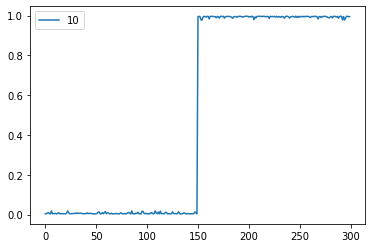

In [450]:
# for C in np.logspace(-2,2,5):

clf = svm.SVC(probability=True,C=C,kernel='rbf')
clf.fit(X, Y)
y = clf.predict_proba(X)[:,0]

plt.plot(y,label = C)
plt.legend()

print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))


In [596]:
def pred(gram,Y,alphas):
    label = -1.*np.logical_not(Y)+1.*Y
    return gram.dot(alphas*label)

def run_SVM_get_pred(K, gram,Y,C = 1, X= None, Z = None):

    alphas = SVM(K,Y,C=C)
    alphas = np.squeeze(alphas)

    label = -1.*np.logical_not(Y)+1.*Y
    alphas = np.squeeze(alphas)

    y = pred(gram,Y,alphas)

    return pred(gram,Y,alphas)


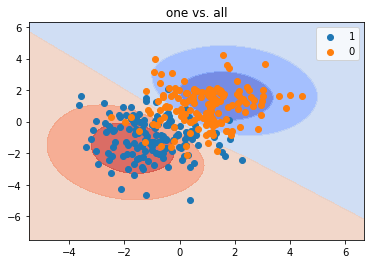

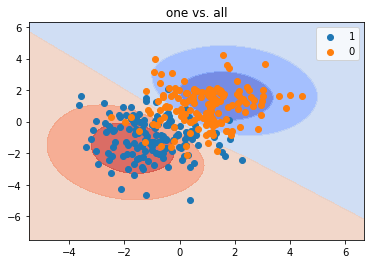

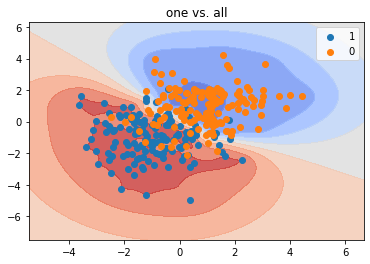

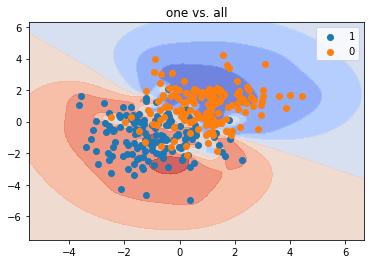

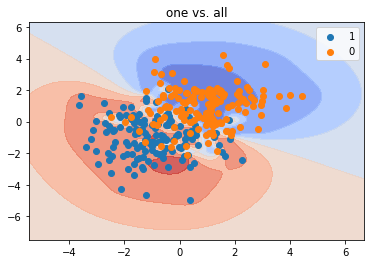

In [597]:
from scipy.spatial import distance

def linear_K(A,B):
    return np.dot(A , B.T) * 1.
   
def RBF_K(A,B,RBF_sig=1):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)


def run_SVM_and_plot_contours(X,Y, clf = run_SVM_get_pred, n_map = 100, C = 1, get_K = linear_K):

    x_min, x_max = np.min(X[:,0])*1.5,np.max(X[:,0])*1.5
    y_min, y_max = np.min(X[:,1])*1.5,np.max(X[:,1])*1.5

    x_r = np.linspace(x_min,x_max,n_map)
    y_r = np.linspace(y_min,y_max,n_map)
    x_r, y_r = np.meshgrid(x_r,y_r)
    x_r_, y_r_ = np.ndarray.flatten(x_r),np.ndarray.flatten( y_r)
    Z = np.vstack((x_r_,y_r_)).transpose()

    K = get_K(X,X)
    gram = get_K(Z,X)

    y = clf(K,gram,Y,C = C,X = X,Z = Z)

    plt.figure()
    plt.contourf(x_r, y_r, y.reshape(n_map,n_map), cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[Y==1,0],X[Y==1,1],label = '1')
    plt.scatter(X[Y==0,0],X[Y==0,1],label = '0')
    plt.legend()    

# generate data
N = 300
X = np.zeros((N,2))
c1, c2 = [1,1], [-1,-1]
sigma = 1.5
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)

for C in np.logspace(-4,4,5):
    run_SVM_and_plot_contours(X,Y,C= C, get_K =RBF_K)
    plt.title('one vs. all')
    plt.show()


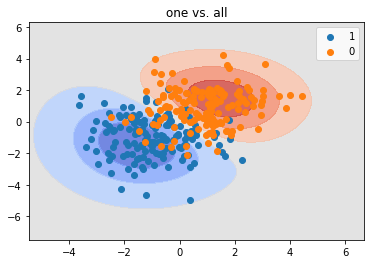

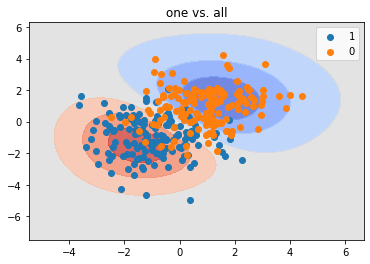

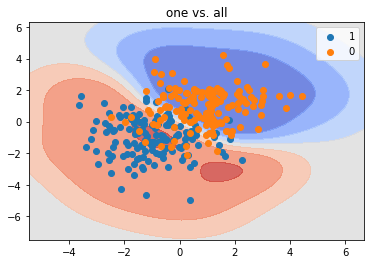

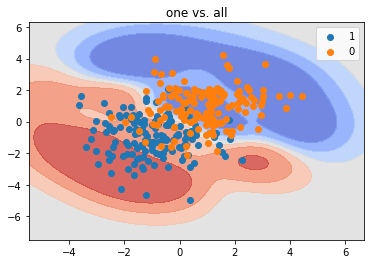

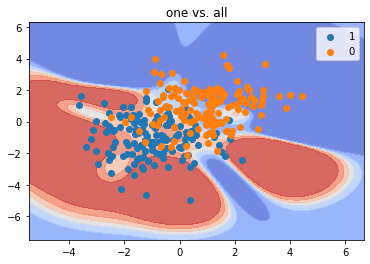

In [598]:

def scikit_SVM(K,gram,Y,C = 1,X=None,Z=None,kernel = 'rbf'):

    clf = svm.SVC(probability=True,C=C,kernel=kernel)
    clf.fit(X, np.logical_not(Y))
    y = clf.predict_proba(Z)
    return y[:,0]


for C in np.logspace(-4,4,5):
    run_SVM_and_plot_contours(X,Y,clf = scikit_SVM,C= C)
    plt.title('one vs. all')
    plt.show()



(500, 2)


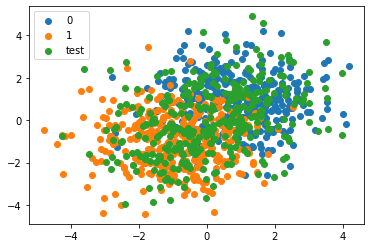

In [591]:
N = 1000
X = np.zeros((N,2))
print(np.random.multivariate_normal(c1,np.eye(2,2),N//2).shape)
c1, c2 = [1,1], [-1,-1]
sigma = 1.5
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)
idx = np.random.choice(range(N),N,replace=False)

split = int(N*2/3)
X, Y = X[idx], Y[idx]
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = '0')
plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = '1')
plt.scatter(X_test[:,0],X_test[:,1],label = 'test')
plt.legend()

30.299338396799605


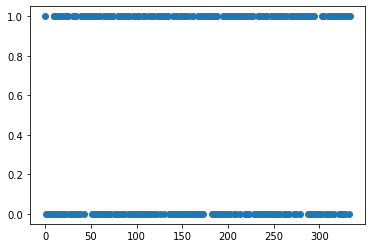

In [595]:
from sklearn.metrics import log_loss

def scikit_SVM(K,gram,Y,C = 1,X=None,Z=None,kernel = 'rbf'):

    clf = svm.SVC(probability=True,C=C,kernel=kernel)
    clf.fit(X, np.logical_not(Y))
    y = clf.predict(Z)
    return y

C = 1
get_K = RBF_K

K = get_K(X_train,X_train)
gram = get_K(X_test,X_train)

clf = scikit_SVM
# clf = run_SVM_get_pred
y = clf(K,gram,Y_train,C = C,X = X_train,Z = X_test)
plt.plot(y,'o')

print(log_loss(Y_test,y>0.5))

[3.9295925083029903, 3.9295925083029903, 3.9295925083029903, 3.9295925083029903, 3.9295925083029903, 3.9295925083029903, 4.033002018467394, 4.136413922636079, 4.033002018467394, 4.756878165635344]


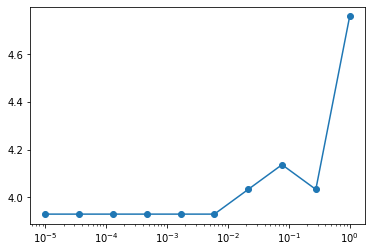

In [594]:
res = []
clf = scikit_SVM
clf = run_SVM_get_pred
C_list = np.logspace(-5,0,10)
for C in C_list:
    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))
    res.append(log_loss(Y_test,y>0))
plt.plot(C_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('C')
print(res)